# Model Training for Ultrasound Image Reconstruction
This notebook sets up the baseline training pipeline using ultrasound data.  

In [129]:
# === File system & utilities ===
import os
import random
from glob import glob
from tqdm import tqdm

# === Core scientific stack ===
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# === PyTorch core ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchinfo import summary

# === Machine learning / validation ===
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

## Import everything external

Function to load ground truth images.

In [130]:
def load_gt_stack(img_paths, repeats_per_img=75):
    """
    Loads and normalizes GT ultrasound envelope images to [0, 1] in linear scale.
    Repeats each GT image to match plane waves.

    Returns:
        torch.Tensor: [N, H, W] in linear scale, normalized to [0, 1]
    """
    img_tensor = []

    # First pass: find global max across all images
    global_max = 0.0
    for path in img_paths:
        img = torch.tensor(sio.loadmat(path)['img'])
        img_mag = torch.abs(img)
        global_max = max(global_max, img_mag.max().item())

    print(f"[INFO] Global max (linear magnitude): {global_max:.4f}")

    # Second pass: normalize each image using global max
    for path in tqdm(sorted(img_paths)):
        img = torch.tensor(sio.loadmat(path)['img'])  # complex
        img = torch.abs(img)  # envelope
        img = img / (global_max + 1e-8)  # normalize to [0, 1]

        for _ in range(repeats_per_img):
            img_tensor.append(img)

    return torch.stack(img_tensor)  # shape: [N, H, W]

Function to read radio frequency ultrasound data.

In [131]:
# -------------------------------
# 1. Normalize RF frame to [-1, 1]
# -------------------------------
def normalize_rf_frame(rf):
    min_val, max_val = rf.min(), rf.max()
    if max_val - min_val > 0:
        return 2 * (rf - min_val) / (max_val - min_val) - 1
    else:
        return torch.zeros_like(rf)

# -------------------------------
# 2. Pad RF frame to fixed depth
# -------------------------------
def pad_rf_frame(rf, target_depth):
    current_depth = rf.shape[0]
    pad_len = target_depth - current_depth
    if pad_len > 0:
        return F.pad(rf, (0, 0, 0, pad_len))  # Pad along samples axis
    else:
        return rf[:target_depth, :]  # Truncate if needed

# -------------------------------
# 3. Load + process RF tensor
# -------------------------------
def load_rf_stack(rf_paths, target_depth=1800):
    rf_tensor = []

    for path in tqdm(sorted(rf_paths)):
        rf_raw = sio.loadmat(path)['rf_raw']  # [samples, 128, 75]

        for i in range(rf_raw.shape[2]):  # loop over plane waves
            rf = rf_raw[:, :, i]  # [samples, 128]
            rf = torch.tensor(rf, dtype=torch.float32)

            rf = normalize_rf_frame(rf)
            rf = pad_rf_frame(rf, target_depth)

            rf_tensor.append(rf)

    return torch.stack(rf_tensor)  # shape: [N, target_depth, 128]

Visualization of ground truth images and ultrasound data

In [132]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_gt_db(gt_tensor, idx=0, clip_percentiles=(1, 99)):
    """
    Visualizes a GT image in dB scale with percentile-based clipping for better contrast.
    
    Args:
        gt_tensor (torch.Tensor): Input tensor of shape [N, H, W] or [N, 1, H, W].
        idx (int): Index of the image to visualize.
        clip_percentiles (tuple): Percentiles for contrast clipping (e.g., (1, 99)).
    """
    gt = gt_tensor[idx].detach().cpu().numpy()
    if gt.ndim == 3 and gt.shape[0] == 1:
        gt = gt[0]  # remove channel dimension if present

    gt_mag = np.abs(gt)
    gt_db = 20 * np.log10(gt_mag + 1e-6)

    # Percentile-based clipping
    vmin = np.percentile(gt_db, clip_percentiles[0])
    vmax = np.percentile(gt_db, clip_percentiles[1])
    gt_db = np.clip(gt_db, vmin, vmax)

    plt.imshow(gt_db, cmap='gray', aspect='auto', vmin=-80, vmax=vmax)
    plt.title(f"GT Image #{idx} (dB scale)")
    plt.xlabel('Lateral')
    plt.ylabel('Depth')
    plt.colorbar(label='dB')
    plt.show()


def visualize_gt_linear(gt_tensor, idx=0):
    gt = gt_tensor[idx].detach().cpu().numpy()
    gt_mag = np.abs(gt)
    gt_mag /= np.max(gt_mag) + 1e-8  # normalize to [0, 1] for visualization

    plt.imshow(gt_mag, cmap='gray', aspect='auto')
    plt.title(f"GT Image #{idx} (Linear scale)")
    plt.xlabel('Lateral')
    plt.ylabel('Depth')
    plt.colorbar(label='Amplitude (normalized)')
    plt.show()


def visualize_rf_line(rf_tensor, file_idx=0, pw_idx=0, ch_idx=0):
    """
    Visualize a single RF A-line from a given rf_tensor [N, D, C].

    Args:
        rf_tensor (torch.Tensor): shape [N, D, C]
        file_idx (int): which RF sample to visualize
        pw_idx (int): not used (for legacy compatibility)
        ch_idx (int): which transducer channel to plot
    """
    if file_idx >= rf_tensor.shape[0]:
        raise ValueError("Invalid file index")
    if ch_idx >= rf_tensor.shape[2]:
        raise ValueError("Invalid channel index")

    a_line = rf_tensor[file_idx, :, ch_idx]  # shape: [depth]
    
    # Plot
    plt.plot(a_line.cpu().numpy())
    plt.title(f"A-line (Sample #{file_idx}, Channel #{ch_idx})")
    plt.xlabel("Sample (depth)")
    plt.ylabel("Amplitude (normalized)")
    plt.grid(True)
    plt.show()

Function to compute SSIM and PSNR.

In [133]:
def compute_metrics(y_true, y_pred):
    """
    Computes PSNR and SSIM between two numpy arrays.

    Args:
        y_true (np.ndarray): Ground truth image, shape (H, W) or (1, H, W)
        y_pred (np.ndarray): Predicted image, shape (H, W) or (1, H, W)

    Returns:
        tuple: (PSNR, SSIM) float values
    """
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)

    assert y_true.shape == y_pred.shape, f"Shape mismatch: {y_true.shape} vs {y_pred.shape}"
    assert y_true.ndim == 2, f"Expected 2D arrays after squeeze, got {y_true.ndim}D"

    psnr_val = psnr(y_true, y_pred, data_range=1.0)
    ssim_val = ssim(y_true, y_pred, data_range=1.0)

    return psnr_val, ssim_val


Function to determine training loss.

In [134]:
import torch
import torch.nn.functional as F
from piq import SSIMLoss  # SSIM from piq

# Instantiate the SSIM loss function globally (reuse it)
ssim_fn = SSIMLoss(data_range=1.0)

def ssim_loss(pred, target):
    """Returns SSIM loss using piq."""
    return ssim_fn(pred, target)

def mae_loss(pred, target):
    """Mean Absolute Error (L1) loss."""
    return F.l1_loss(pred, target)

def combined_loss(pred, target, alpha=0.84):
    """
    Weighted combination of SSIM and MAE losses.
    alpha = weight for SSIM, (1-alpha) = weight for MAE.
    """
    ssim_component = ssim_loss(pred, target)
    mae_component = mae_loss(pred, target)
    return alpha * ssim_component + (1 - alpha) * mae_component


## Custom ResNet Class

In [135]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout=0.2):
        super(BasicBlock, self).__init__()
        stride = 2 if downsample else 1
        self.dropout = nn.Dropout2d(p=dropout)

        self.conv1  =  nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)
        self.conv2  =  nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)         

        self.downsample = downsample or (in_channels != out_channels)
        if self.downsample:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        out = self.activation(self.conv1(x))
        out = self.dropout(out)
        out = self.conv2(out)
        out += self.shortcut(x)
        return self.activation(out)


class CustomResNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=32, output_shape=(387, 609)):
        super(CustomResNet, self).__init__()
        self.output_shape = output_shape

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer1 = nn.Sequential(
            BasicBlock(base_channels, base_channels),
            BasicBlock(base_channels, base_channels)
        )

        self.layer2 = nn.Sequential(
            BasicBlock(base_channels, base_channels * 2, downsample=True),
            BasicBlock(base_channels * 2, base_channels * 2)
        )

        self.layer3 = nn.Sequential(
            BasicBlock(base_channels * 2, base_channels * 4, downsample=True),
            BasicBlock(base_channels * 4, base_channels * 4)
        )

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_channels * 4, base_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_channels * 2, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.final = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x):
        x = self.stem(x)             # [B, 32, 1800, 128]
        x = self.layer1(x)           # [B, 32, 1800, 128]
        x = self.layer2(x)           # [B, 64, 900, 64]
        x = self.layer3(x)           # [B, 128, 450, 32]
        x = self.upsample(x)         # [B, 32, 1800, 128]
        x = self.final(x)            # [B, 1, 1800, 128]
        x = torch.sigmoid(x)
        return F.interpolate(x, size=self.output_shape, mode='bilinear', align_corners=False)


# Custom U-Net Class

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.block(x)

def center_crop_or_pad(enc_feat, dec_feat):
    """Align encoder feature to decoder size for concatenation."""
    _, _, h, w = dec_feat.shape
    return F.interpolate(enc_feat, size=(h, w), mode='bilinear', align_corners=False)

class DeepUNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=32, output_shape=(387, 609)):
        super().__init__()
        self.output_shape = output_shape

        # Encoder
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(base_channels * 2, base_channels * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(base_channels * 4, base_channels * 8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 16)

        # Decoder
        self.up4 = nn.ConvTranspose2d(base_channels * 16, base_channels * 8, 2, stride=2)
        self.dec4 = DoubleConv(base_channels * 16, base_channels * 8)

        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec3 = DoubleConv(base_channels * 8, base_channels * 4)

        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec2 = DoubleConv(base_channels * 4, base_channels * 2)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec1 = DoubleConv(base_channels * 2, base_channels)

        # Final conv
        self.final = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)             # -> [B, 32, H, W]
        x2 = self.enc2(self.pool1(x1))# -> [B, 64, H/2, W/2]
        x3 = self.enc3(self.pool2(x2))# -> [B, 128, H/4, W/4]
        x4 = self.enc4(self.pool3(x3))# -> [B, 256, H/8, W/8]
        x_b = self.bottleneck(self.pool4(x4)) # [B, 512, H/16, W/16]

        d4 = self.up4(x_b)
        x4 = center_crop_or_pad(x4, d4)
        d4 = self.dec4(torch.cat([d4, x4], dim=1))

        d3 = self.up3(d4)
        x3 = center_crop_or_pad(x3, d3)
        d3 = self.dec3(torch.cat([d3, x3], dim=1))

        d2 = self.up2(d3)
        x2 = center_crop_or_pad(x2, d2)
        d2 = self.dec2(torch.cat([d2, x2], dim=1))

        d1 = self.up1(d2)
        x1 = center_crop_or_pad(x1, d1)
        d1 = self.dec1(torch.cat([d1, x1], dim=1))

        out = self.final(d1)
        out = torch.sigmoid(out)
        return F.interpolate(out, size=self.output_shape, mode='bilinear', align_corners=False)


In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# try this, 969 k params
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.op(x)

class MicroUNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=32, output_shape=(387, 609)):
        super().__init__()
        self.output_shape = output_shape

        # Encoder
        self.enc1 = ConvBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ConvBlock(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ConvBlock(base_channels * 2, base_channels * 4)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_channels * 4, base_channels * 8)

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = ConvBlock(base_channels * 8 + base_channels * 4, base_channels * 4)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = ConvBlock(base_channels * 4 + base_channels * 2, base_channels * 2)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = ConvBlock(base_channels * 2 + base_channels, base_channels)

        # Final layer
        self.final = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))

        # Bottleneck
        x_b = self.bottleneck(self.pool3(x3))

        # Decoder
        d3 = self.up3(x_b)
        d3 = self.dec3(torch.cat([d3, x3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, x2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, x1], dim=1))

        # Output
        out = self.final(d1)
        out = torch.sigmoid(out)
        return F.interpolate(out, size=self.output_shape, mode='bilinear', align_corners=False)

## Configuration
Define all the training parameters in one variable.

In [138]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"✅ CUDA is available! Using GPU: {device_name}")
else:
    print("❌ CUDA is not available. Training will be **very slow** on CPU.")

❌ CUDA is not available. Training will be **very slow** on CPU.


In [139]:
CONFIG = {
    'model_name': 'unet',           # options: 'resnet', 'unet', 'effunet'
    'loss_function': 'combined',          # options: 'ssim', 'mae', 'combined'
    'batch_size': 8,
    'lr': 1e-3,
    'epochs': 100,
    'input_size': None,               # we set it based on the max depth of processed .mat files
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    'data_dir_rf': os.path.join('..', 'data', 'raw'),
    'data_dir_img': os.path.join('..', 'data', 'processed'),
    'checkpoints_dir': None, # will be set below
}

# Set checkpoint path
CONFIG['checkpoints_dir'] = os.path.join('..', 'checkpoints', CONFIG['model_name'])

# (Optional) Create the directory if it doesn't exist
os.makedirs(CONFIG['checkpoints_dir'], exist_ok=True)


In [140]:
# set config paths in COlab

In [141]:
def get_min_rf_depth(rf_paths):
    depths = []
    for rf_file in rf_paths:
        rf_raw = sio.loadmat(rf_file)['rf_raw']
        depths.append(rf_raw.shape[0])
    return min(depths)

rf_paths = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
CONFIG['input_size'] = (1, 1800, 128) #hardcoded
print(CONFIG['input_size']) # should be [1, 3328, 128]


(1, 1800, 128)


## Data Loading
We assume .mat for input RF data and .mat for the reconstructed image files.

In [142]:
# test rf loading
rf_paths  = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
rf_tensor = load_rf_stack(rf_paths, target_depth=1800)  # Output: [450, 3328, 128]

print("RF tensor shape:", rf_tensor.shape)   # should be [450, 3328, 128]

100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

RF tensor shape: torch.Size([450, 1800, 128])


In [143]:
img_paths = sorted(glob(os.path.join(CONFIG['data_dir_img'], 'img_*.mat')))
gt_tensor = load_gt_stack(img_paths)  # [450, 378, 609]

print("GT tensor shape:", gt_tensor.shape)   # should be [450, 378, 609]

[INFO] Global max (linear magnitude): 907.6446


100%|██████████| 6/6 [00:00<00:00, 47.48it/s]

GT tensor shape: torch.Size([450, 387, 609])


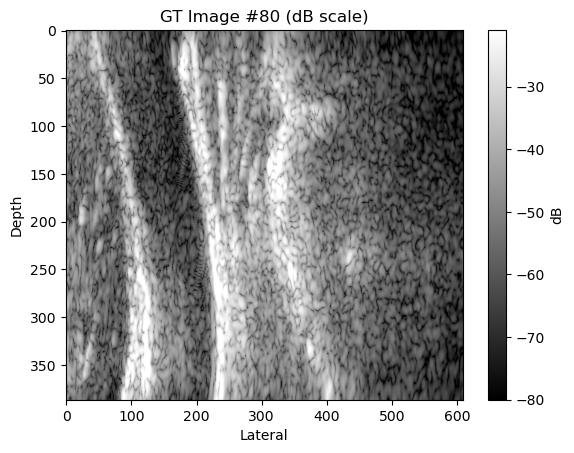

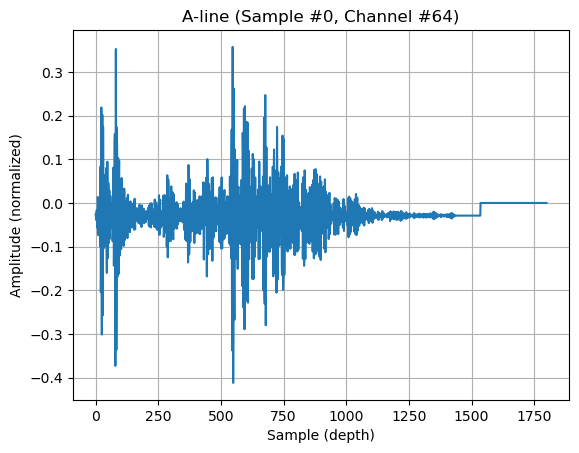

In [144]:
visualize_gt_db(gt_tensor, idx=80)
visualize_rf_line(rf_tensor, file_idx=0, pw_idx=10, ch_idx=64)

## Data Augmentation
In this part we create new tensors with augmented GT images and zeroes out transducer channels. Output of this section should be DataLoader.

In [145]:
# we need train test split first
from sklearn.model_selection import train_test_split

# Indices for splitting
indices = np.arange(rf_tensor.shape[0])
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Split tensors
rf_train, gt_train = rf_tensor[train_idx], gt_tensor[train_idx]
rf_val,   gt_val   = rf_tensor[val_idx],   gt_tensor[val_idx]
rf_test,  gt_test  = rf_tensor[test_idx],  gt_tensor[test_idx]

Original shape: torch.Size([360, 387, 609])
Augmented shape: torch.Size([360, 387, 609])


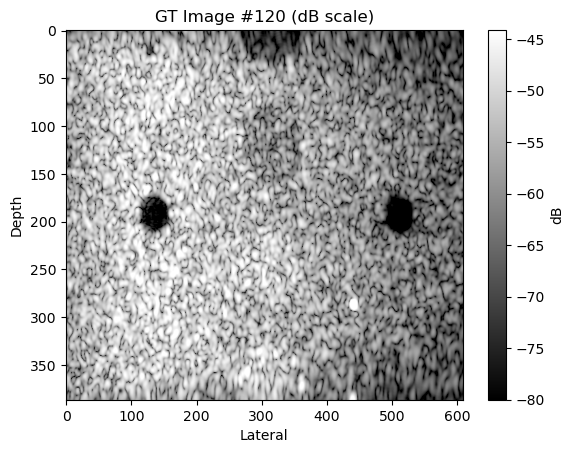

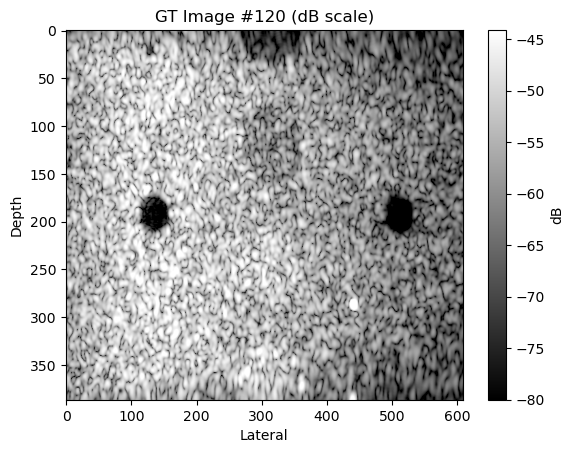

In [160]:
def augment_gt_tensor(gt_tensor, contrast_factor=1.0001, noise_std=0.0005, prob=0.75):
    """
    Apply contrast jitter and Gaussian noise to GT images without breaking global normalization.

    Args:
        gt_tensor (torch.Tensor): [N, H, W] GT images, already in [0, 1].
        contrast_factor (float): Small factor for contrast jitter.
        noise_std (float): Std dev of Gaussian noise.
        prob (float): Probability to augment a given image.

    Returns:
        torch.Tensor: [N, H, W] augmented, still in [0, 1].
    """
    augmented = []

    for i in range(gt_tensor.shape[0]):
        img = gt_tensor[i].clone()

        if torch.rand(1).item() < prob:
            # Apply contrast jitter around midpoint
            img = (img - 0.5) * contrast_factor + 0.5

            # Add Gaussian noise
            img = img + torch.randn_like(img) * noise_std

            # Clip to preserve physical meaning (don't re-normalize)
            img = torch.clamp(img, 0.0, 1.0)

        augmented.append(img)

    return torch.stack(augmented)



# ==== Test it on gt_train ====
gt_augmented = augment_gt_tensor(gt_train)

print("Original shape:", gt_train.shape)
print("Augmented shape:", gt_augmented.shape)


index_for_testing = 120
visualize_gt_db(gt_train, idx=index_for_testing)
visualize_gt_db(gt_augmented, idx=index_for_testing)


RF original shape:  torch.Size([360, 1800, 128])
RF augmented shape: torch.Size([360, 1800, 128])
Dropped channel indices: [17, 21, 26, 49, 57, 59, 64, 75, 86, 112, 113, 126]


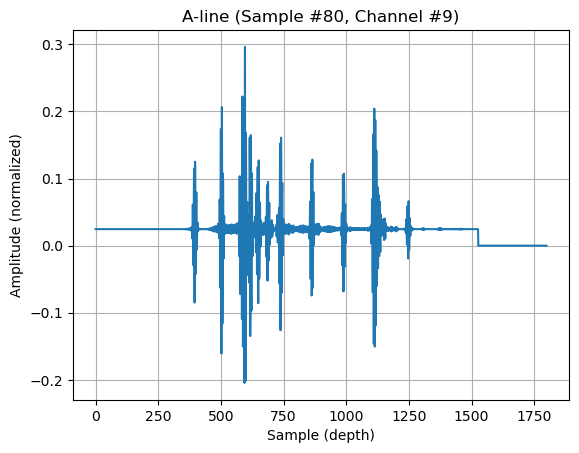

In [147]:
def zero_out_rf_channels(rf_tensor, dropout_rate=0.1):
    """
    Randomly zero out dropout_rate fraction of transducer channels.

    Args:
        rf_tensor (torch.Tensor): [N, D, C] RF data
        dropout_rate (float): Fraction of channels to zero out

    Returns:
        rf_aug (torch.Tensor): Augmented tensor with dropped channels
        dropped_channels (list[int]): Indices of zeroed channels
    """
    N, D, C = rf_tensor.shape
    num_drop = int(C * dropout_rate)
    dropped_channels = sorted(random.sample(range(C), num_drop))

    # Clone to avoid modifying original
    rf_aug = rf_tensor.clone()
    rf_aug[:, :, dropped_channels] = 0

    return rf_aug, dropped_channels

# ==== Test it on rf_train ====
rf_augmented, zeroed_idx = zero_out_rf_channels(rf_train, dropout_rate=0.1)

print("RF original shape: ", rf_train.shape)
print("RF augmented shape:", rf_augmented.shape)
print("Dropped channel indices:", zeroed_idx)

# === Visual sanity check ===
from utils.visualize_raw import visualize_rf_line

file_idx = 80  # plane wave index to visualize
pw_idx   = 8
ch_idx   = 9
# should look flatlined (all zeros)
visualize_rf_line(rf_augmented, file_idx=file_idx, pw_idx=pw_idx, ch_idx=ch_idx)


In [148]:
from torch.utils.data import TensorDataset
# === 1. Augment GT for training ===
gt_train_augmented = augment_gt_tensor(gt_train)

# === 2. Zero out 10% of channels in RF training data ===
rf_train_subsampled, dropped_channels = zero_out_rf_channels(rf_train, dropout_rate=0.1)
print("Dropped channels (for sanity check):", dropped_channels)

# === 3. Create TensorDatasets ===
train_clean_ds = TensorDataset(rf_train.unsqueeze(1), gt_train_augmented.unsqueeze(1))
train_noisy_ds = TensorDataset(rf_train_subsampled.unsqueeze(1), gt_train_augmented.unsqueeze(1))
val_ds         = TensorDataset(rf_val.unsqueeze(1), gt_val.unsqueeze(1))
test_ds        = TensorDataset(rf_test.unsqueeze(1), gt_test.unsqueeze(1))

# (Optional) Print shapes to verify
print("Train Clean:", train_clean_ds[0][0].shape, train_clean_ds[0][1].shape)
print("Train Noisy:", train_noisy_ds[0][0].shape, train_noisy_ds[0][1].shape)
print("Val:", val_ds[0][0].shape, val_ds[0][1].shape)
print("Test:", test_ds[0][0].shape, test_ds[0][1].shape)

Dropped channels (for sanity check): [6, 16, 31, 54, 55, 65, 73, 93, 94, 111, 122, 124]
Train Clean: torch.Size([1, 1800, 128]) torch.Size([1, 387, 609])
Train Noisy: torch.Size([1, 1800, 128]) torch.Size([1, 387, 609])
Val: torch.Size([1, 1800, 128]) torch.Size([1, 387, 609])
Test: torch.Size([1, 1800, 128]) torch.Size([1, 387, 609])


In [149]:
from torch.utils.data import DataLoader, ConcatDataset

train_combined = ConcatDataset([train_clean_ds, train_noisy_ds])

train_loader = DataLoader(train_clean_ds, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False)


In [150]:
# Check a single batch from each loader
train_batch = next(iter(train_loader))
val_batch   = next(iter(val_loader))
test_batch  = next(iter(test_loader))

for name, batch in zip(["Train", "Val", "Test"], [train_batch, val_batch, test_batch]):
    rf, gt = batch
    print(f"{name} RF shape: {rf.shape}, GT shape: {gt.shape}")


Train RF shape: torch.Size([8, 1, 1800, 128]), GT shape: torch.Size([8, 1, 387, 609])
Val RF shape: torch.Size([8, 1, 1800, 128]), GT shape: torch.Size([8, 1, 387, 609])
Test RF shape: torch.Size([8, 1, 1800, 128]), GT shape: torch.Size([8, 1, 387, 609])


## Model Architecture
Here we define the model architecture used for training.

In [165]:
if CONFIG['model_name'] == 'resnet':
    model = CustomResNet().to(device=CONFIG['device'])
elif CONFIG['model_name'] == 'unet':
    model = MicroUNet().to(device=CONFIG['device'])
elif CONFIG['model_name'] == 'effunet':
    model = EfficientUNetBeamformer()

In [152]:
# we define standard optimizer and scheduler, loss is defined later based on user CONFIG
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [153]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0

    # Select loss function once
    if CONFIG['loss_function'] == 'ssim':
        loss_fn = ssim_loss
    elif CONFIG['loss_function'] == 'mae':
        loss_fn = mae_loss
    elif CONFIG['loss_function'] == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {CONFIG['loss_function']}")

    for x, y in tqdm(loader):
        x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
        if y.ndim == 3:
            y = y.unsqueeze(1)  # [B, H, W] → [B, 1, H, W]

        print("shape of y is", y.shape)
        optimizer.zero_grad()
        y_pred = model(x)
        print("shape of y_pred is", y_pred.shape)

        print("target range:", y.min().item(), y.max().item())
        print("pred range:", y_pred.min().item(), y_pred.max().item())

        loss = loss_fn(y_pred, y)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # we use this if training becomes unstable
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [154]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0

    # Select loss function once
    if CONFIG['loss_function'] == 'ssim':
        loss_fn = ssim_loss
    elif CONFIG['loss_function'] == 'mae':
        loss_fn = mae_loss
    elif CONFIG['loss_function'] == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {CONFIG['loss_function']}")

    print("===> Starting training epoch")
    print(f"Model is on device: {next(model.parameters()).device}")
    print(f"Loss function: {CONFIG['loss_function']}")
    print(f"Total batches: {len(loader)}")

    for batch_idx, (x, y) in enumerate(tqdm(loader)):
        print(f"\n--- Batch {batch_idx+1}/{len(loader)} ---")
        print(f"Input shape before to(): {x.shape}, Target shape: {y.shape}")

        x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])

        if y.ndim == 3:
            y = y.unsqueeze(1)  # [B, H, W] → [B, 1, H, W]
       #     print("Unsqueezed target shape:", y.shape)

       # print("Input shape after to():", x.shape)
       # print("Target shape after to():", y.shape)
        print("Target value range:", y.min().item(), y.max().item())

        optimizer.zero_grad()

        y_pred = model(x)
       # print("Prediction shape:", y_pred.shape)
        print("Prediction value range:", y_pred.min().item(), y_pred.max().item())

        loss = loss_fn(y_pred, y)
        print("Loss value:", loss.item())

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"\n===> Epoch finished. Avg loss: {avg_loss:.4f}")
    return avg_loss


In [155]:
def validate(model, loader):
    model.eval()
    val_loss = 0
    total_psnr, total_ssim = 0.0, 0.0
    total_count = 0  # <- make sure to initialize

    if CONFIG['loss_function'] == 'ssim':
        loss_fn = ssim_loss
    elif CONFIG['loss_function'] == 'mae':
        loss_fn = mae_loss
    elif CONFIG['loss_function'] == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {CONFIG['loss_function']}")

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Validating"):
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # Detach and move to CPU
            preds = y_pred.detach().cpu().float().numpy()
            targets = y.detach().cpu().float().numpy()

            # Compute metrics per sample
            batch_size = preds.shape[0]
            total_count += batch_size  # <- update count

            for i in range(batch_size):
                pred_i = preds[i, 0]    # remove channel dim: [1, H, W] → [H, W]
                target_i = targets[i, 0]

                psnr, ssim = compute_metrics(target_i, pred_i)
                total_psnr += psnr
                total_ssim += ssim

    return (
        val_loss / len(loader),
        total_psnr / total_count,
        total_ssim / total_count
    )

## Model Training
In this part we set up the training loop, train the model and then save the parameters of the final one.

In [161]:
# Make sure you've mounted Google Drive beforehand:
# from google.colab import drive
# drive.mount('/content/drive')

# Set this path once (for example, in CONFIG or above your training loop)
best_model_path = "/content/drive/MyDrive/ReconstructUS_checkpoints/best_model.pth"
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in tqdm(range(CONFIG['epochs'])):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_psnr, val_ssim = validate(model, val_loader)
    scheduler.step()

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0

        # Save checkpoint to Google Drive
        torch.save(model.state_dict(), best_model_path)
        print(f">>> Saved new best model to {best_model_path}")
    else:
        epochs_no_improve += 1
        print(f">>> No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

  0%|          | 0/100 [00:00<?, ?it/s]

===> Starting training epoch
Model is on device: cpu
Loss function: combined
Total batches: 45



--- Batch 1/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 1.0
Prediction value range: 0.002196450252085924 0.9898021221160889
Loss value: 0.9034437537193298



--- Batch 2/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 0.3722284138202667
Prediction value range: 0.16685503721237183 0.9971345663070679
Loss value: 0.8950344324111938



--- Batch 3/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 1.0
Prediction value range: 0.15672282874584198 0.9999348521232605
Loss value: 0.8941671252250671



--- Batch 4/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 0.9997148513793945
Prediction value range: 0.263528048992157 0.9999672174453735
Loss value: 0.8935456275939941



--- Batch 5/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 1.0
Prediction value range: 0.24269433319568634 0.9999110698699951
Loss value: 0.888157069683075



--- Batch 6/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 1.0
Prediction value range: 0.26891064643859863 0.9999909400939941
Loss value: 0.8920636177062988



--- Batch 7/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 0.26897549629211426
Prediction value range: 0.24562525749206543 0.9999876022338867
Loss value: 0.8734932541847229



--- Batch 8/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 1.0
Prediction value range: 0.2182818502187729 0.9999884366989136
Loss value: 0.8877667784690857



--- Batch 9/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 1.0
Prediction value range: 0.24827983975410461 0.9999963045120239
Loss value: 0.8763445615768433



--- Batch 10/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 1.0
Prediction value range: 0.20494386553764343 0.9999659061431885
Loss value: 0.8830371499061584



--- Batch 11/45 ---
Input shape before to(): torch.Size([8, 1, 1800, 128]), Target shape: torch.Size([8, 1, 387, 609])
Target value range: 0.0 1.0
Prediction value range: 0.17206549644470215 0.9999839067459106
Loss value: 0.8779215216636658


  0%|          | 0/100 [02:42<?, ?it/s]


KeyboardInterrupt: 

## Model Visualization
We visualize one example of the reconstructed images.

In [9]:
def visualize_prediction_vs_gt_db(gt_tensor, pred_tensor, idx=0, clim=(-60, 0)):
    """
    Visualizes GT and predicted images side by side in dB scale.

    Args:
        gt_tensor (torch.Tensor): shape [B, 1, H, W]
        pred_tensor (torch.Tensor): shape [B, 1, H, W]
        idx (int): index in the batch to visualize
        clim (tuple): dB range to clip the display, e.g., (-60, 0)
    """
    gt = gt_tensor[idx, 0].detach().cpu().numpy()
    pred = pred_tensor[idx, 0].detach().cpu().numpy()

    gt_db = 20 * np.log10(np.abs(gt) / np.max(gt) + 1e-8)
    pred_db = 20 * np.log10(np.abs(pred) / np.max(pred) + 1e-8)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(gt_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    axs[0].set_title("Ground Truth (dB)")
    axs[0].axis('off')

    axs[1].imshow(pred_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    axs[1].set_title("Reconstruction (dB)")
    axs[1].axis('off')

    plt.suptitle(f"Sample #{idx}")
    plt.colorbar(ax=axs[1], label='dB')
    plt.tight_layout()
    plt.show()


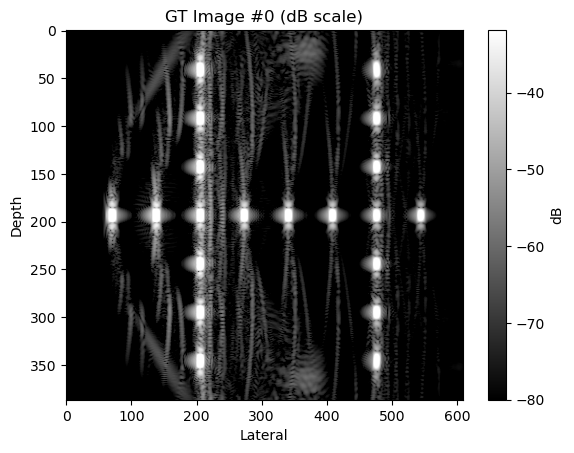

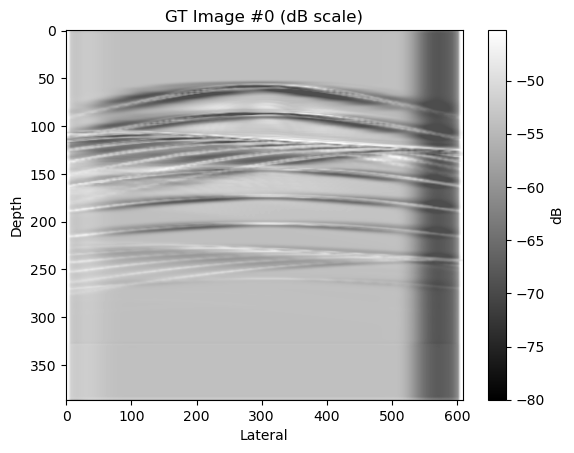

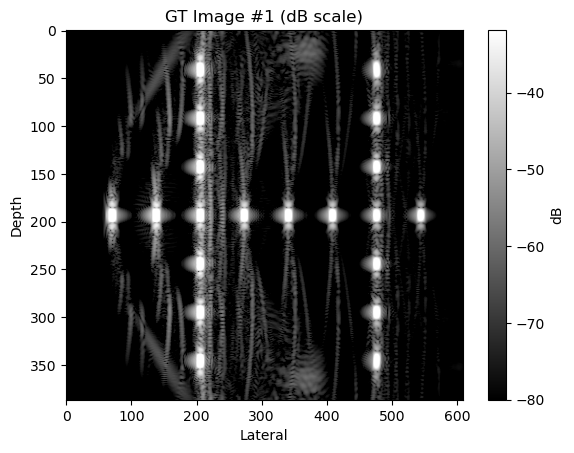

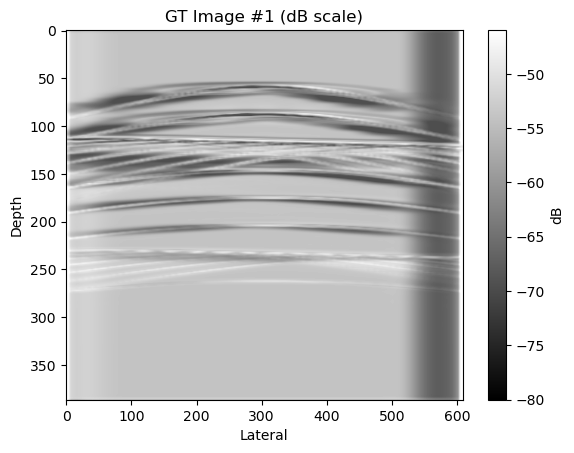

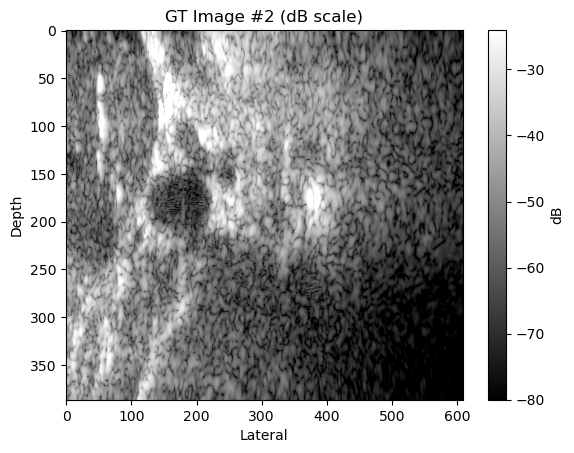

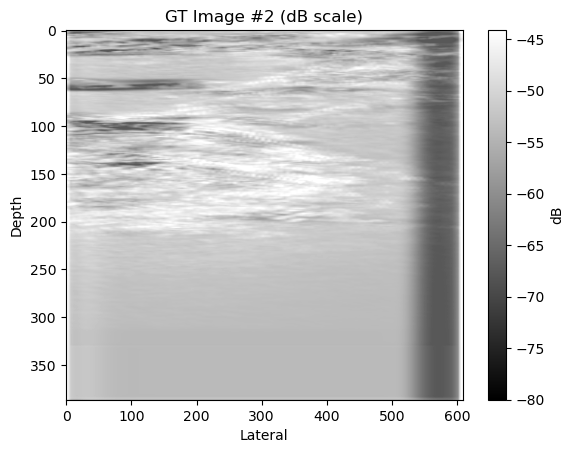

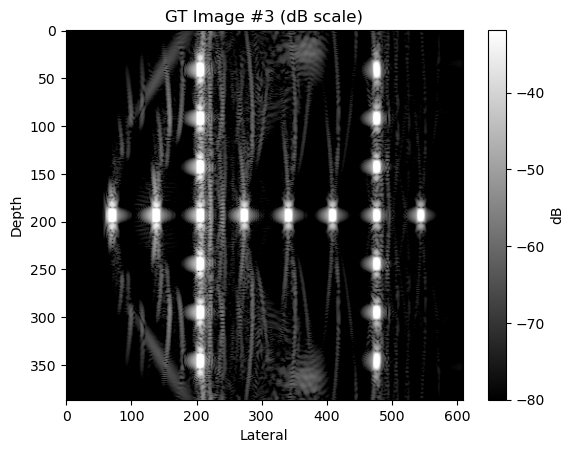

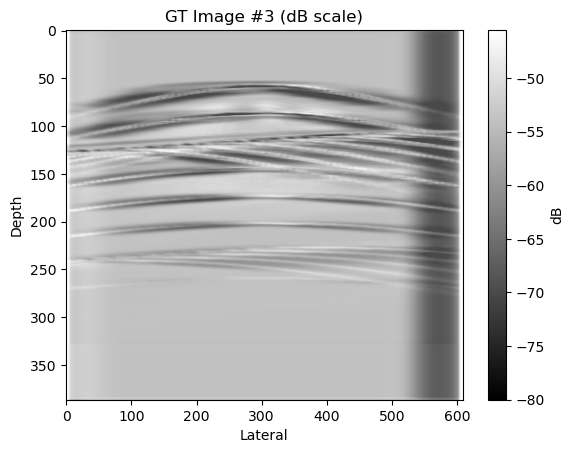

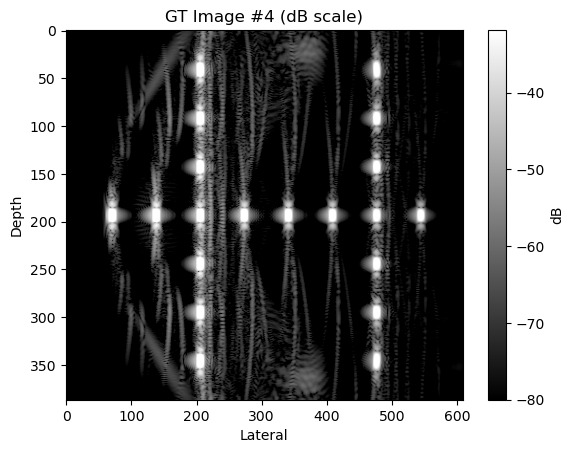

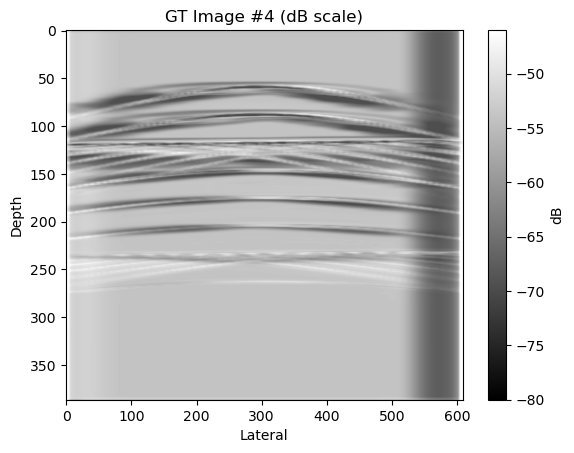

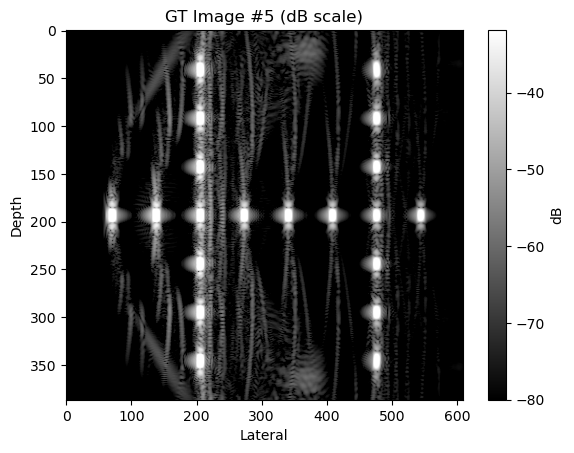

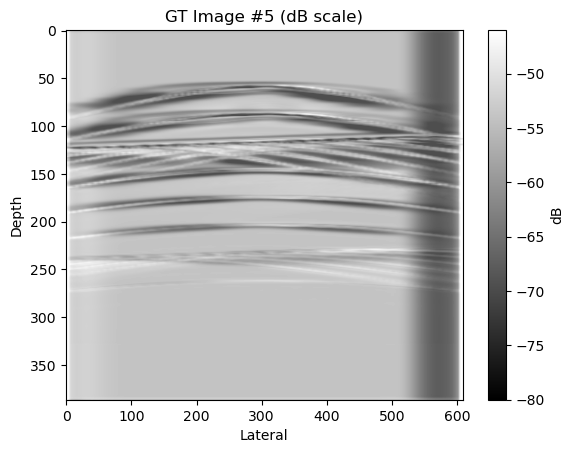

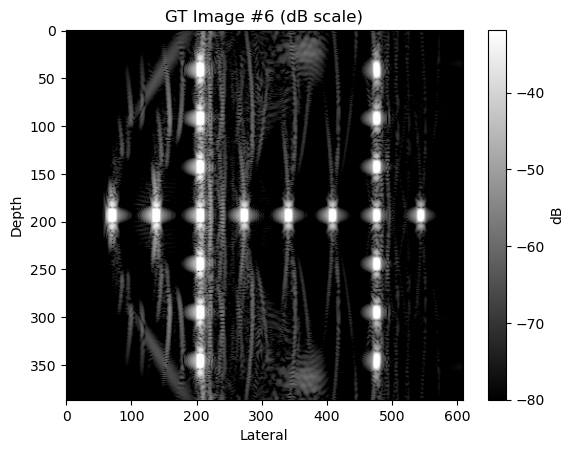

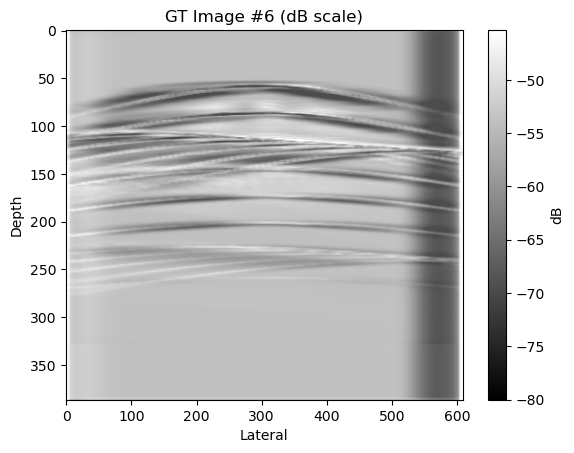

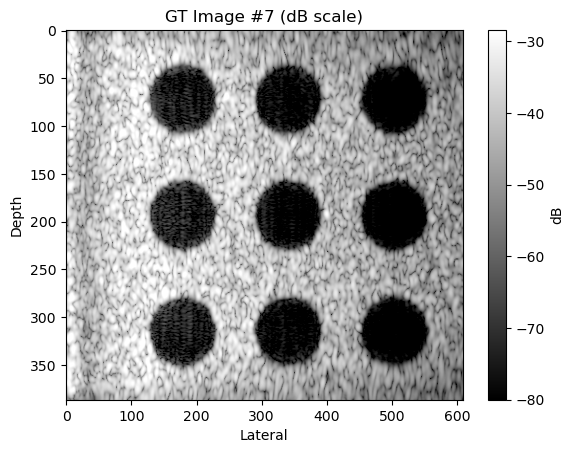

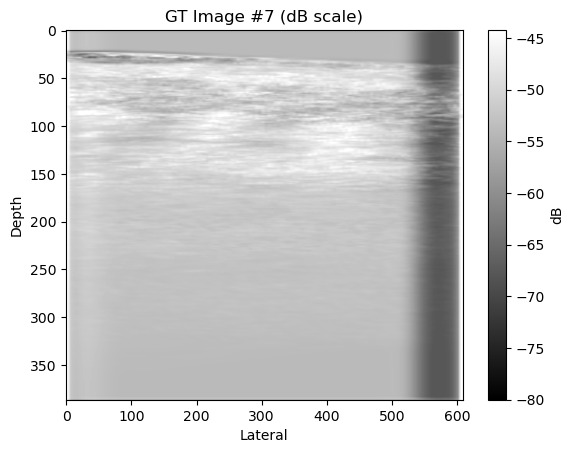

In [167]:
# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['checkpoints_dir'], 'best_model_MUNaug.pth'), map_location=torch.device('cpu')))
model.eval()

# Get validation batch
x_val, y_val = next(iter(test_loader))
x_val, y_val = x_val.to(CONFIG['device']), y_val.to(CONFIG['device'])

# Predict
with torch.no_grad():
    preds = model(x_val)

# Visualize a few samples
for i in range(8):
    visualize_gt_db(y_val.squeeze(), idx=i)
    visualize_gt_db(preds.squeeze(), idx=i)
